---
title: "15-生存分析"
subtitle: "Kaplan-Meier检验和Log-Rank检验"
author: "Simon Zhou"
date: "2025-05-08"
format: 
    html:
        code-fold: false
        fig_caption: true
        number-sections: true
        toc: true
        toc-depth: 2
---

In [1]:
import stata_setup
stata_setup.config('C:/Program Files/Stata18', 'mp', splash=False)

## 生存分析

1. 描述一个组内个体的生存时间
   - 寿命表法(Life tables methods)
   - 非参数Kaplan-Meier曲线
2. 比较两个或多个组的生存时间
   - Log-rank test
3. 研究生存时间和变量之间的关系
    - 半参数Cox比例风险模型
    - 参数生存分析模型

## K-M曲线的历史

1. 1958年，Dr. Kaplan和DrMeier 介绍了一种全新的、解决随访期间RightCensoring问题的生存分析方法
2. 特点:精确地记录并利用每个个体发生终点事件的具体时间，在任何一个终点事件发生的时间点计算出一个新的、基于之前所有信息的Cumulative survival
3. 优点:
    - 相比于Life-table method，更加充分地利用了信息，给出更准确的统计量
    - 非参数估计方法:不要求总体的分布形式，因此非常适合生存分析时使用
    - K-M曲线可以很直观地表现出两组或多组的生存率或死亡率，适合在文章中展示

## 导入数据

使用 **Patient Survival in Drug Trial** 数据集

In [26]:
%%stata
webuse drugtr,clear

(Patient survival in drug trial)


将数据恢复成普通的数据格式：`stset,clear`

>Stata已经将这个数据集设置成了生存数据的格式，导入数据集后，将数
据集恢复成普通的数据格式，这样才是我们在临床研究中见到的数据结构。

In [27]:
%%stata
stset,clear

## 数据集的初步观察

In [28]:
%%stata
list in 5/10


     +------------------------------+
     | studyt~e   died   drug   age |
     |------------------------------|
  5. |        4      1      0    56 |
  6. |        4      1      0    67 |
  7. |        5      1      0    63 |
  8. |        5      1      0    58 |
  9. |        8      1      0    56 |
     |------------------------------|
 10. |        8      0      0    58 |
     +------------------------------+


In [29]:
%%stata
codebook drug


-------------------------------------------------------------------------------
drug                                                      Drug type (0=placebo)
-------------------------------------------------------------------------------

                  Type: Numeric (byte)

                 Range: [0,1]                         Units: 1
         Unique values: 2                         Missing .: 0/48

            Tabulation: Freq.  Value
                           20  0
                           28  1


In [30]:
%%stata
codebook studytime


-------------------------------------------------------------------------------
studytime                                        Months to death or end of exp.
-------------------------------------------------------------------------------

                  Type: Numeric (byte)

                 Range: [1,39]                        Units: 1
         Unique values: 28                        Missing .: 0/48

                  Mean:    15.5
             Std. dev.: 10.2563

           Percentiles:     10%       25%       50%       75%       90%
                              4       7.5      12.5        23        32


In [31]:
%%stata
codebook died


-------------------------------------------------------------------------------
died                                                          1 if patient died
-------------------------------------------------------------------------------

                  Type: Numeric (byte)

                 Range: [0,1]                         Units: 1
         Unique values: 2                         Missing .: 0/48

            Tabulation: Freq.  Value
                           17  0
                           31  1


In [32]:
%%stata
codebook age


-------------------------------------------------------------------------------
age                                              Patient's age at start of exp.
-------------------------------------------------------------------------------

                  Type: Numeric (byte)

                 Range: [47,67]                       Units: 1
         Unique values: 18                        Missing .: 0/48

                  Mean: 55.875
             Std. dev.: 5.6592

           Percentiles:    10%       25%       50%       75%       90%
                            49      50.5        56        60        65


## 数据申明——代码操作

1. 告诉Stata: 终点事件(Failure variable),随访时间(Time variable)
2. `stset timevar, failure(failvar[==numlist])`
    - `timevar`: 随访时间变量
    - `failvar`: 终点事件变量
    - `numlist`: 终点时间变量中，哪个(哪些)值代表发生了终点事件?

In [33]:
%%stata
stset studytime,failure(died==1)


Survival-time data settings

         Failure event: died==1
Observed time interval: (0, studytime]
     Exit on or before: failure

--------------------------------------------------------------------------
         48  total observations
          0  exclusions
--------------------------------------------------------------------------
         48  observations remaining, representing
         31  failures in single-record/single-failure data
        744  total analysis time at risk and under observation
                                                At risk from t =         0
                                     Earliest observed entry t =         0
                                          Last observed exit t =        39


## 生存数据再观测

**Notice：**必须要在指定数据集为生存分析数据集之后(stset
之后)才能使用任何其他的 `st` 开始的命令。

In [34]:
%%stata
stsum


        Failure _d: died==1
  Analysis time _t: studytime

         |               Incidence     Number of   |------ Survival time -----|
         | Time at risk       rate      subjects        25%       50%       75%
---------+---------------------------------------------------------------------


   Total |          744   .0416667            48          8        17        33


In [35]:
%%stata
stdescribe


        Failure _d: died==1
  Analysis time _t: studytime

                                   |-------------- Per subject --------------|
Category                   Total        Mean         Min     Median        Max
------------------------------------------------------------------------------
Number of subjects            48   
Number of records             48           1           1          1          1

Entry time (first)                         0           0          0          0
Exit time (final)                       15.5           1       12.5         39

Subjects with gap              0   
Time on gap                    0   
Time at risk                 744        15.5           1       12.5         39

Failures                      31    .6458333           0          1          1
------------------------------------------------------------------------------


In [36]:
%%stata
sts list


        Failure _d: died==1
  Analysis time _t: studytime

Kaplan–Meier survivor function

             At                  Survivor      Std.
  Time     risk   Fail   Lost    function     error     [95% conf. int.]
------------------------------------------------------------------------
     1       48      2      0      0.9583    0.0288     0.8435    0.9894
     2       46      1      0      0.9375    0.0349     0.8186    0.9794
     3       45      1      0      0.9167    0.0399     0.7930    0.9679
     4       44      2      0      0.8750    0.0477     0.7427    0.9418
     5       42      2      0      0.8333    0.0538     0.6943    0.9129
     6       40      2      1      0.7917    0.0586     0.6474    0.8820
     7       37      1      0      0.7703    0.0608     0.6236    0.8656
     8       36      3      1      0.7061    0.0661     0.5546    0.8143
     9       32      0      1      0.7061    0.0661     0.5546    0.8143
    10       31      1      1      0.6833    0.0678  

## K-M曲线的绘制

语法：

```stata
sts graph [if] [in] [,options]
```

`[,options]` 不是必须，可以形如：`,by(var)`，这样就会按照 `var` 的分类绘制不同的线


        Failure _d: died==1
  Analysis time _t: studytime


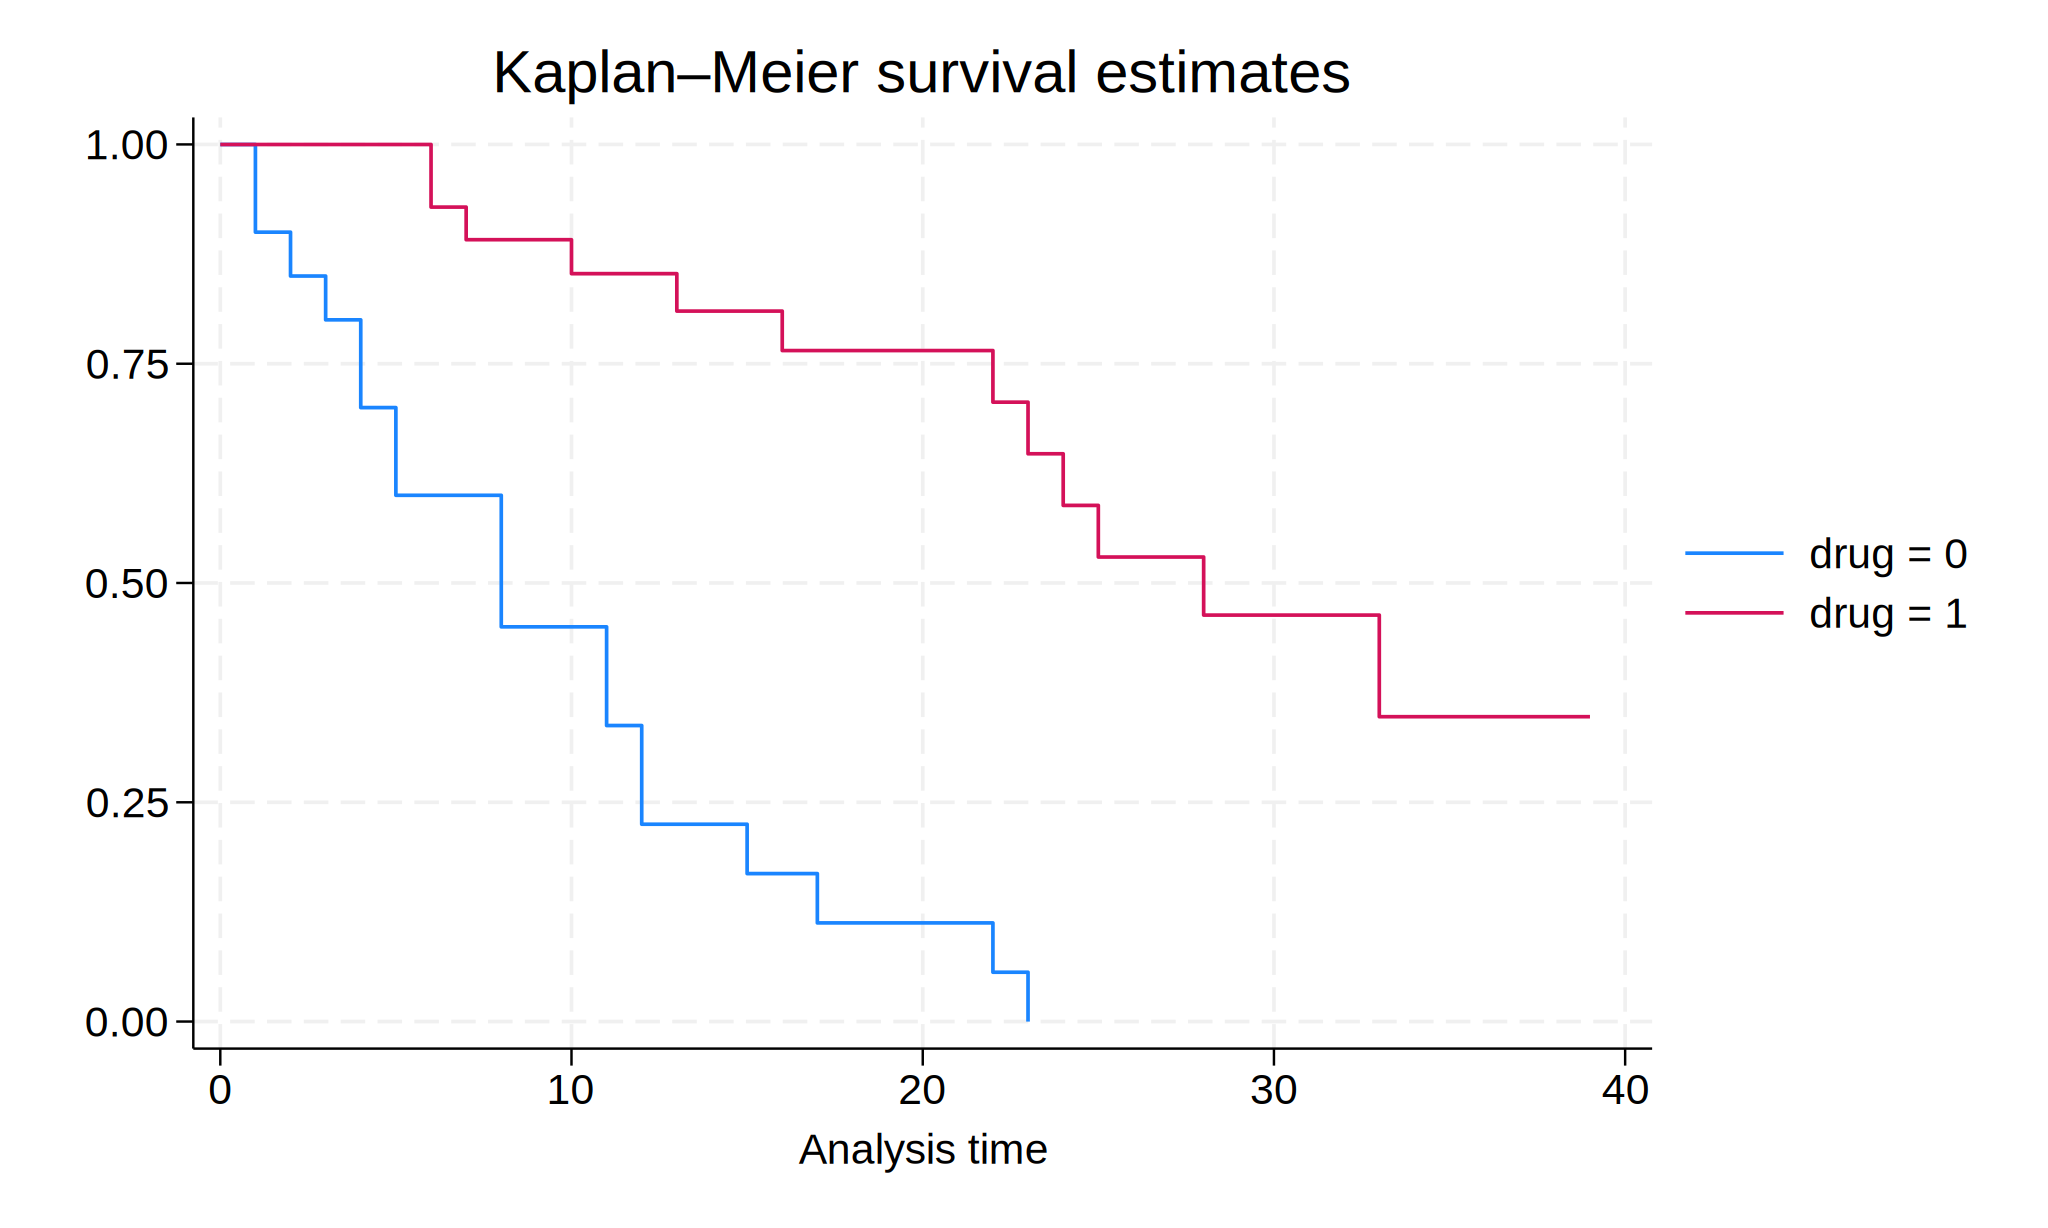

In [37]:
%%stata
sts graph,by(drug)

### 图像展现更多的信息


        Failure _d: died==1
  Analysis time _t: studytime


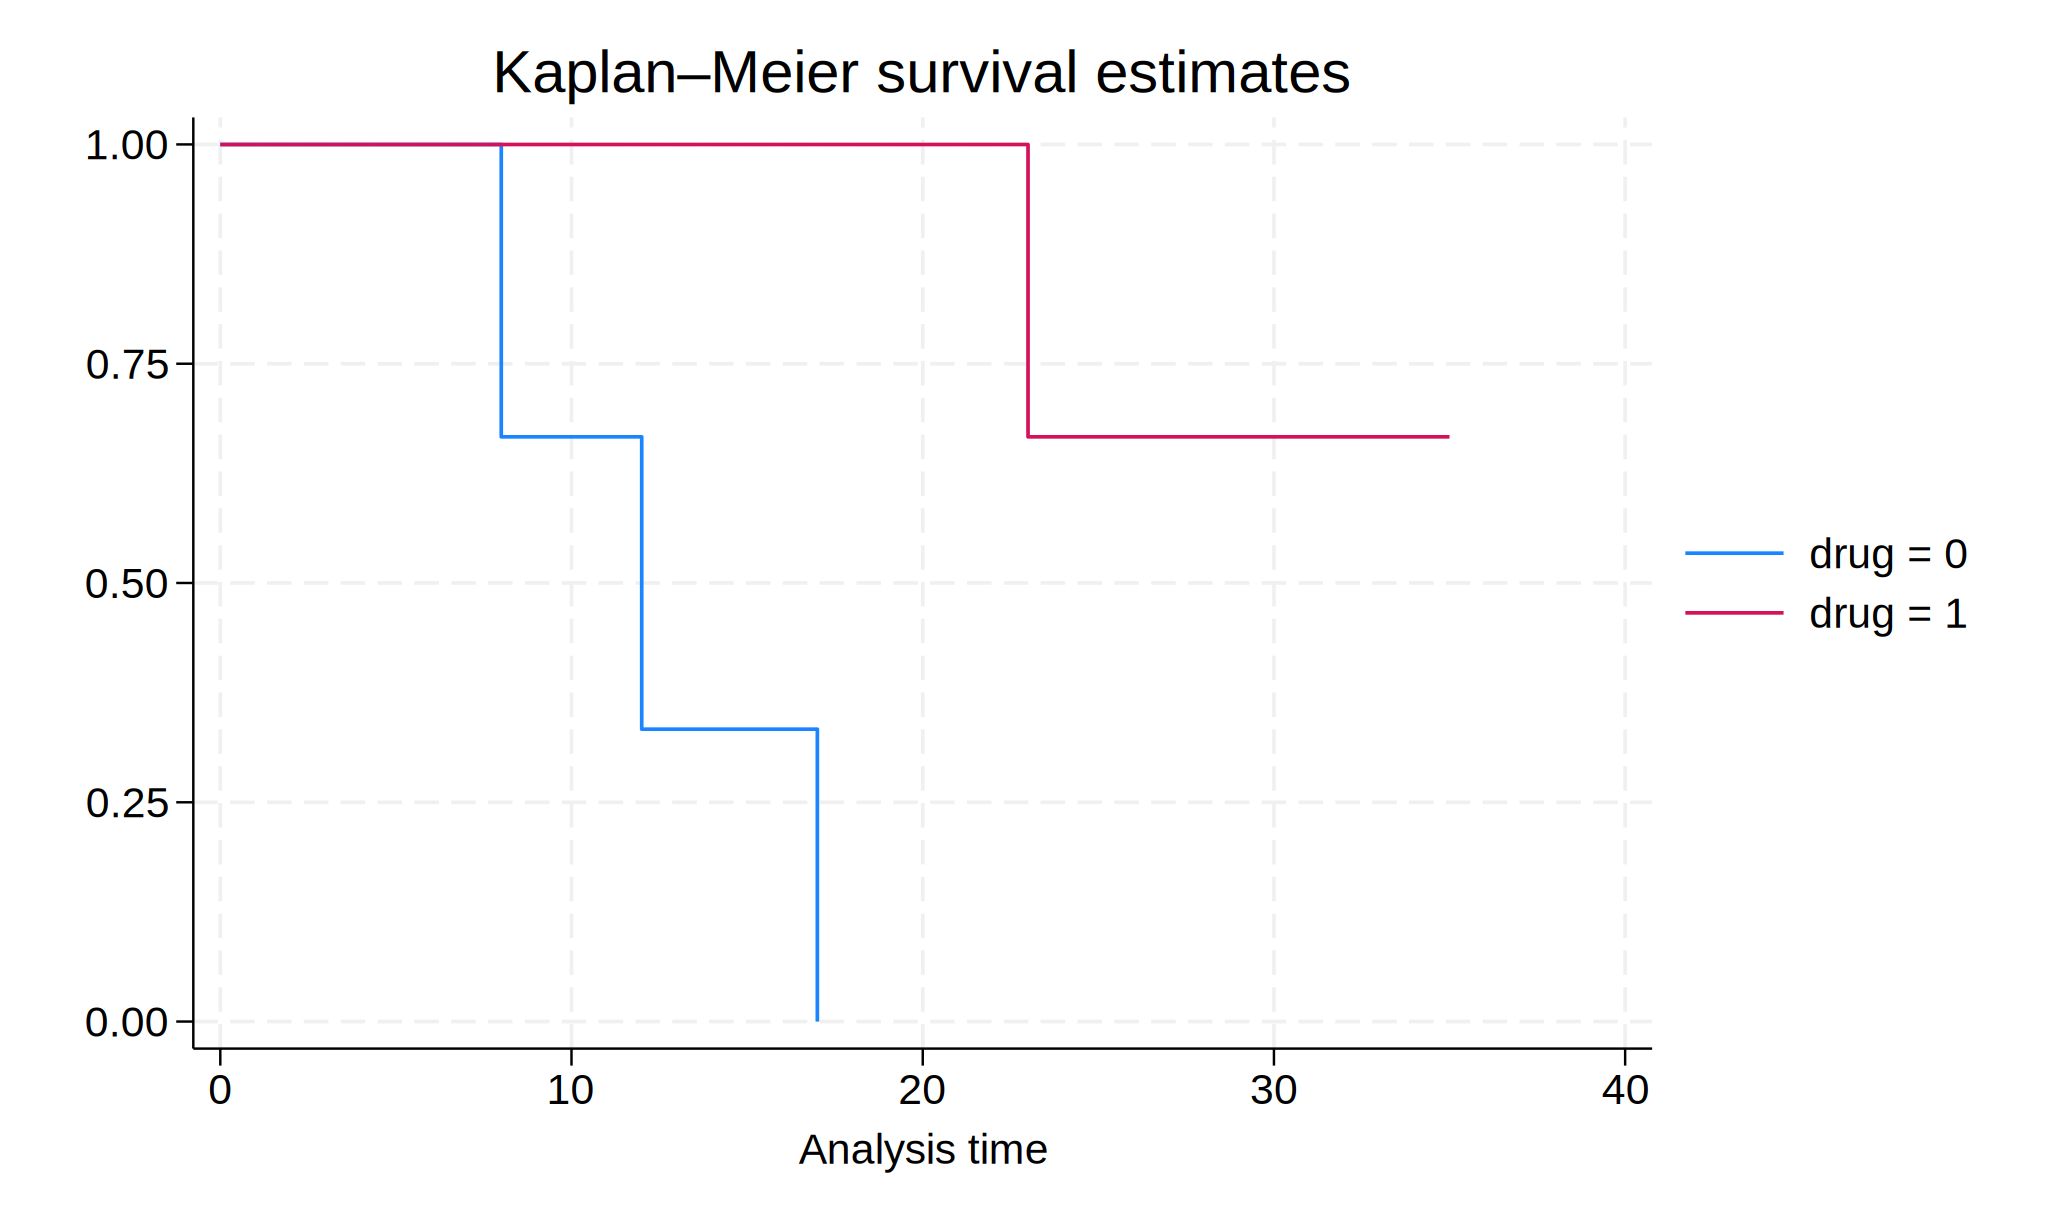

In [38]:
%%stata
sts graph if age<50,by(drug)


        Failure _d: died==1
  Analysis time _t: studytime


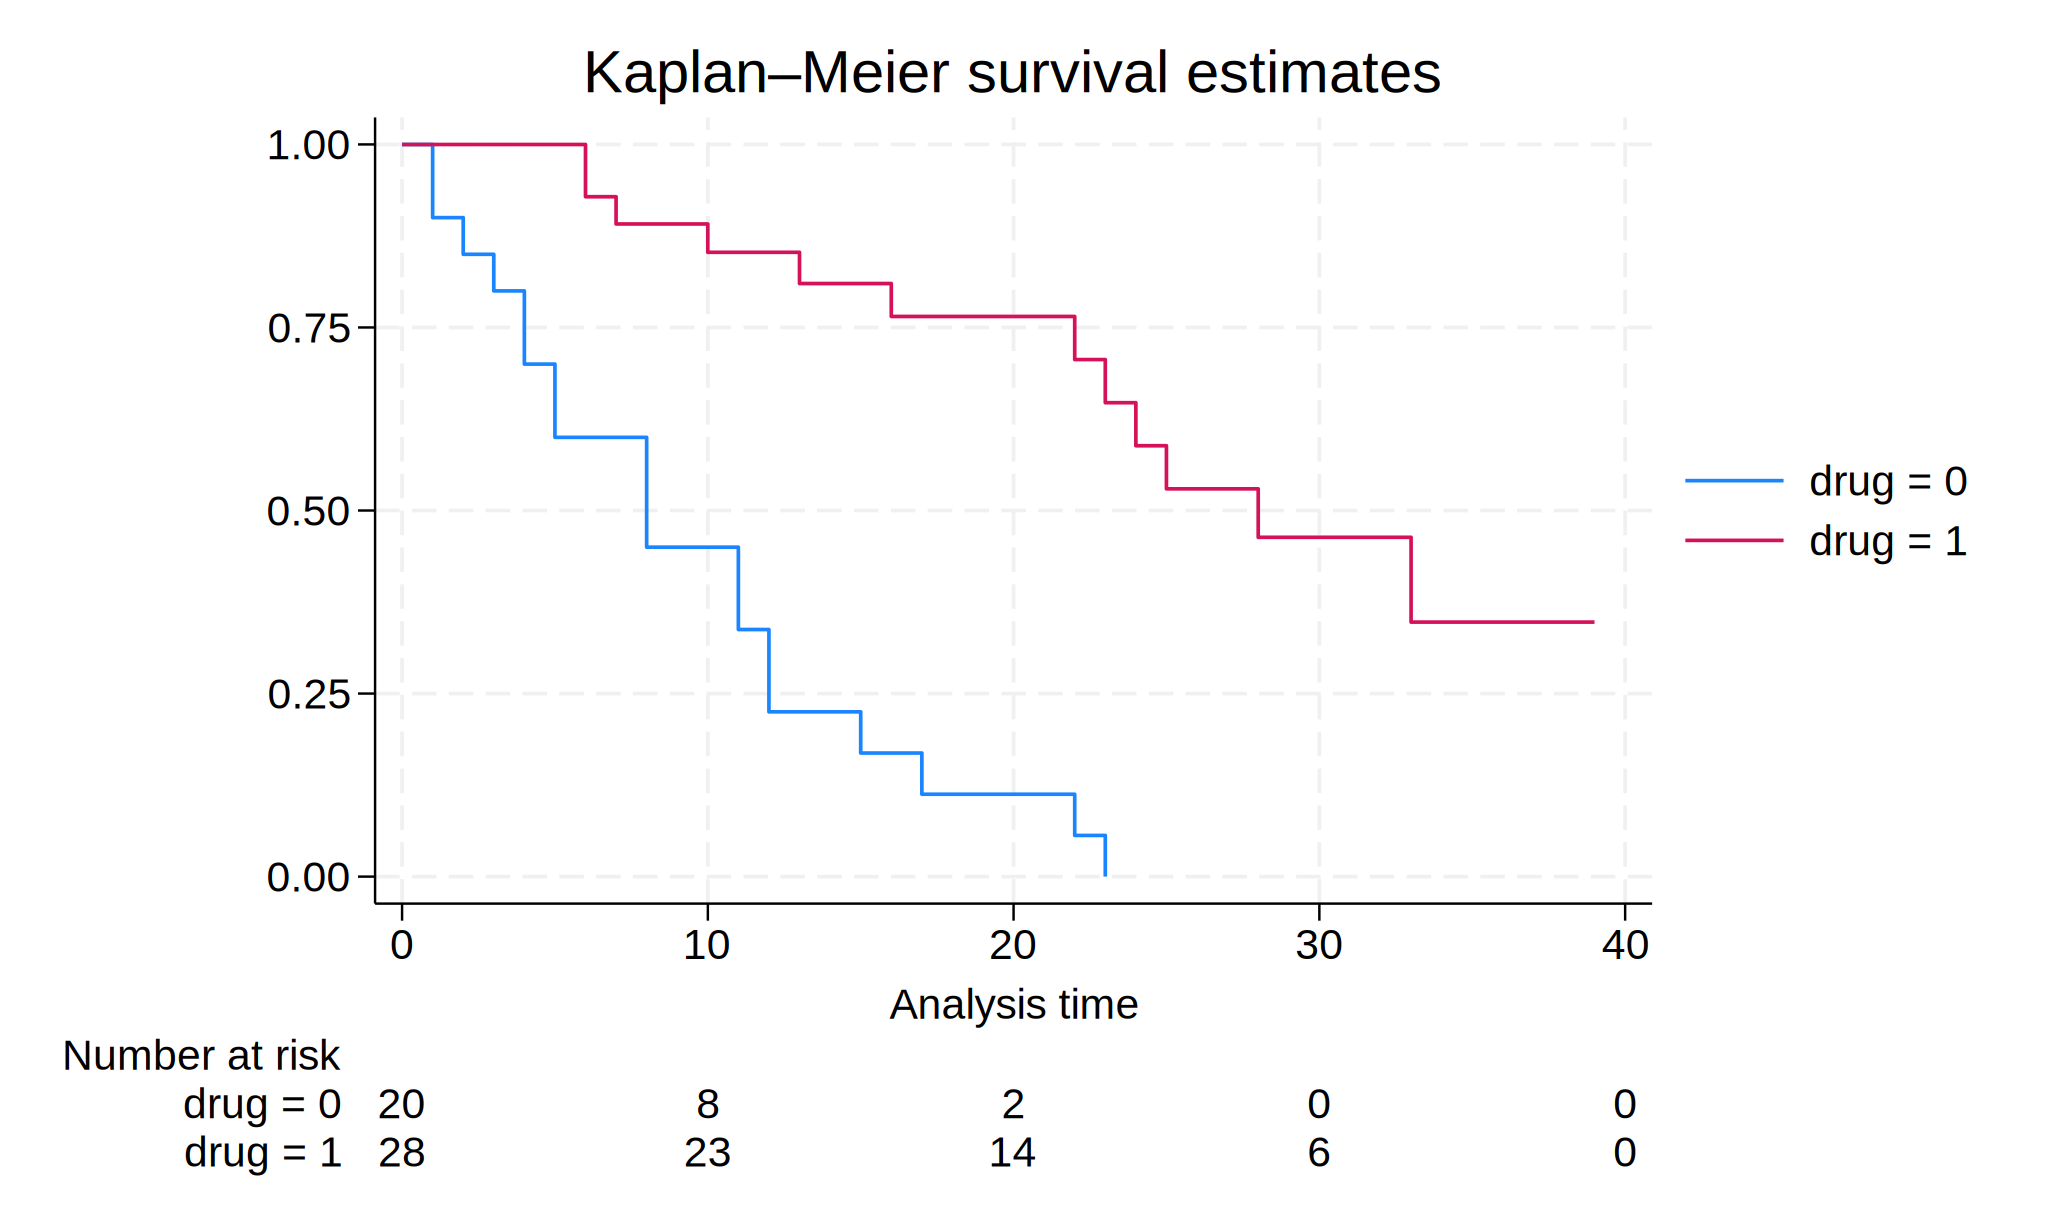

In [39]:
%%stata
sts graph,by(drug) risktable

### 复杂绘图示例

In [47]:
%%stata
label drop drug_label
label define drug_label 0 "安慰剂" 1 "试验药"
label values drug drug_label


. label drop drug_label

. label define drug_label 0 "安慰剂" 1 "试验药"

. label values drug drug_label

. 



. sts graph, ///
>     by(drug) ci atrisk ///
>     xlabel(0(5)40) ylabel(0(0.2)1) ///
>     legend(position(6) ring(1) cols(2) rowgap(1) colgap(1)) ///
>     xtitle("x轴的标签") ytitle("y轴的标签") ///
>     title("这里是标题", size(medsmall)) ///
>     subtitle("这里是副标题", size(small)) ///
>     caption("注释", size(vsmall)) ///
>     note("数据来源：xxx", size(vsmall)) ///
>     graphregion(margin(10 10 10 10)) ///
>     plotregion(margin(5 5 5 5))

        Failure _d: died==1
  Analysis time _t: studytime



. 


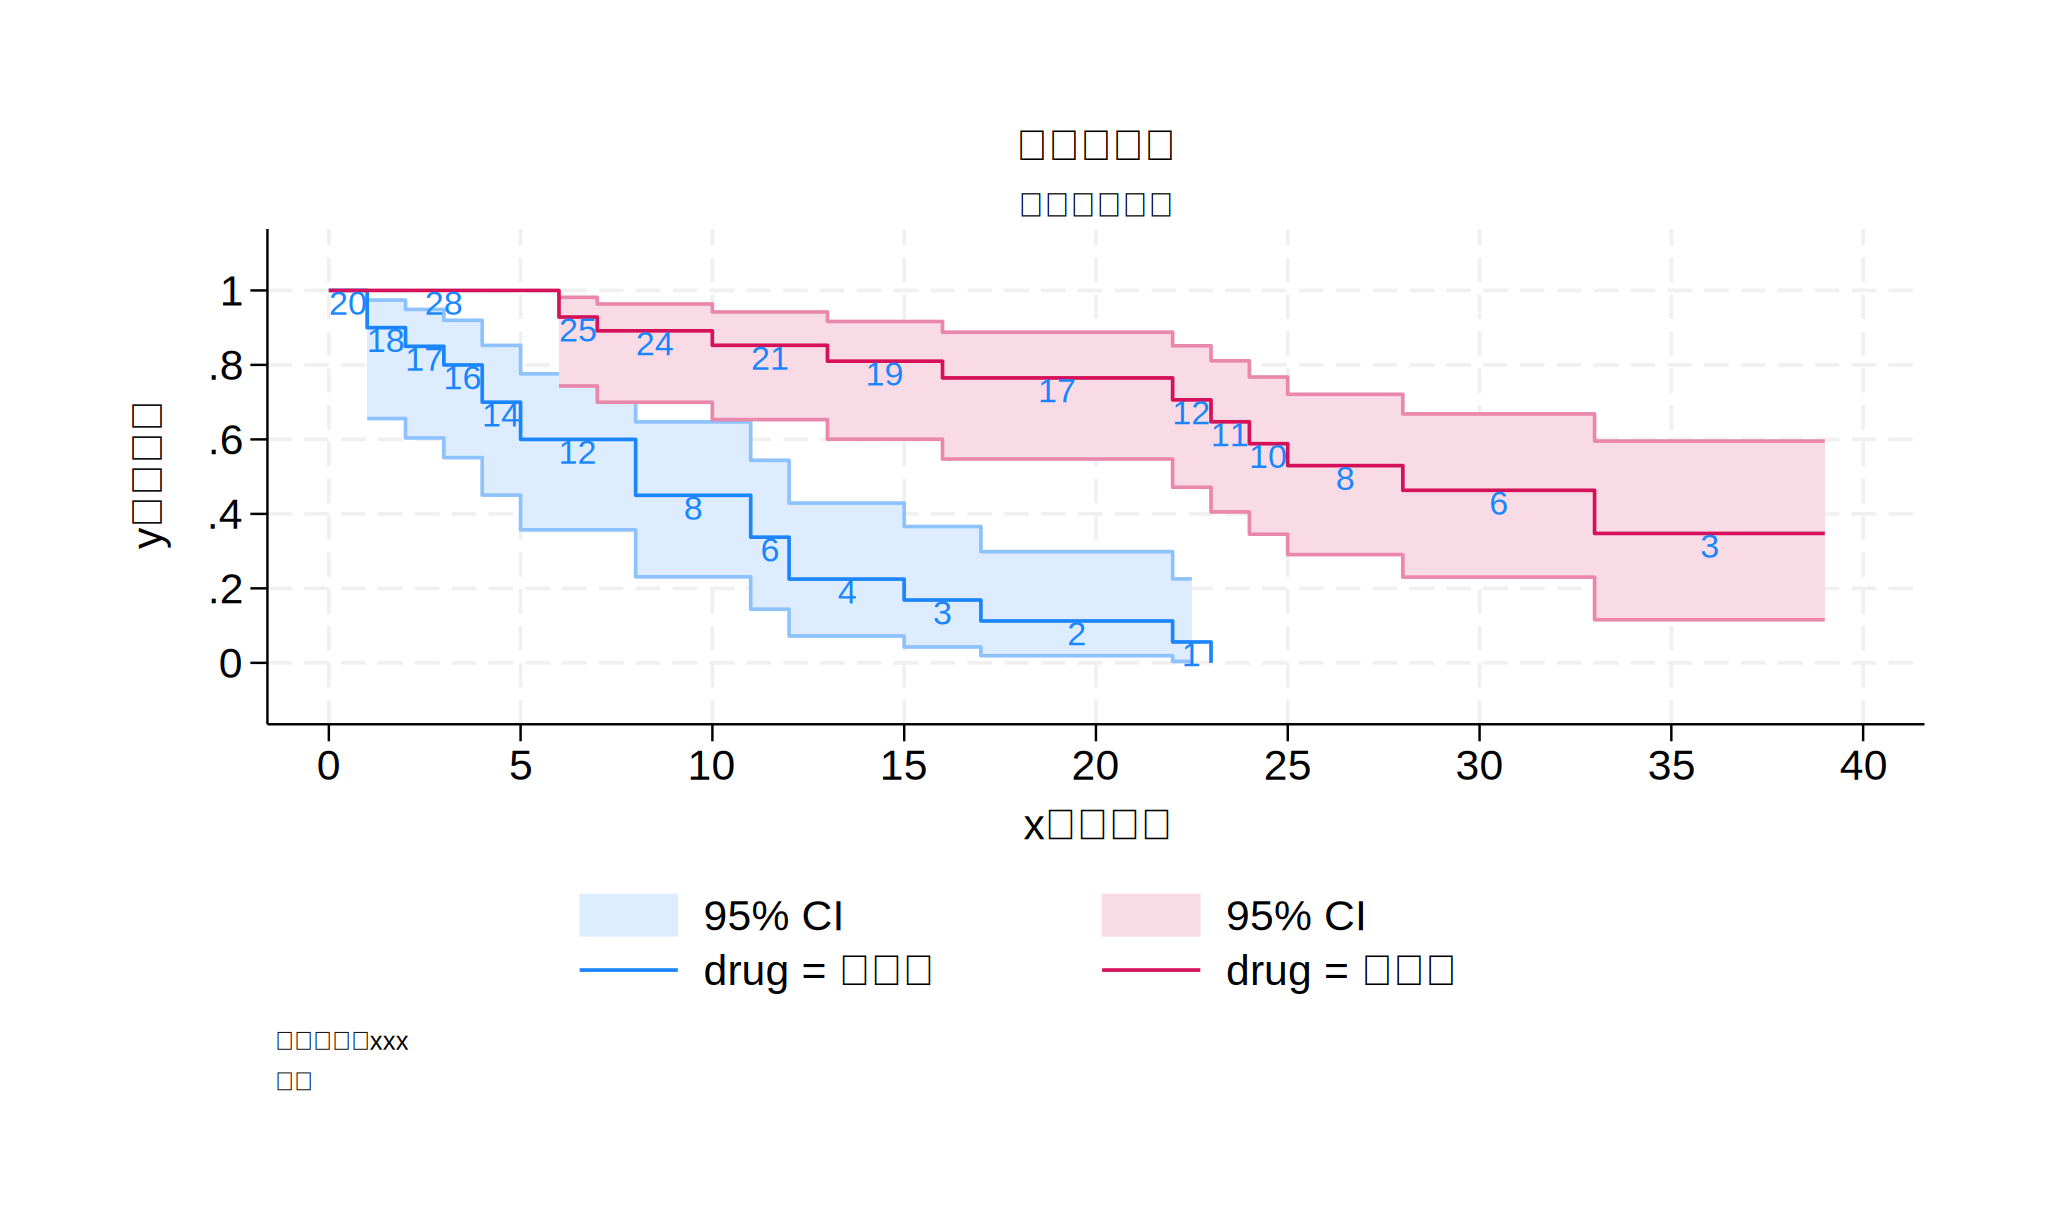

In [48]:
%%stata
sts graph, ///
    by(drug) ci atrisk ///
    xlabel(0(5)40) ylabel(0(0.2)1) ///
    legend(position(6) ring(1) cols(2) rowgap(1) colgap(1)) ///
    xtitle("x轴的标签") ytitle("y轴的标签") ///
    title("这里是标题", size(medsmall)) ///
    subtitle("这里是副标题", size(small)) ///
    caption("注释", size(vsmall)) ///
    note("数据来源：xxx", size(vsmall)) ///
    graphregion(margin(10 10 10 10)) ///
    plotregion(margin(5 5 5 5))


## 检验组间差别（Log-Rank Test）

In [18]:
%%stata
sts test drug


        Failure _d: died==1
  Analysis time _t: studytime

Equality of survivor functions
Log-rank test

      |  Observed       Expected
drug  |    events         events
------+-------------------------
    0 |        19           7.25
    1 |        12          23.75
------+-------------------------
Total |        31          31.00

                chi2(1) =  28.27
                Pr>chi2 = 0.0000
